# Preprocessing Sentinel-2 images

In [1]:
import glob, os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from pathlib import Path

print('All libraries successfully imported!')
print(f'Rasterio : {rasterio.__version__}')

All libraries successfully imported!
Rasterio : 1.0.8


## Set directory

In [2]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

roi_path = f'{work_path}ROI/'
dwl_path = f'{work_path}DOWNLOAD/'


# For each step of the preprocessing,
# a folder will be created to store 
# the intermediary files.

resampled_path = f'{work_path}1_L2A_RESAMPLED/'
clipped_path   = f'{work_path}2_L2A_CLIPPED/'
masked_path    = f'{work_path}3_L2A_MASKED/'

Path(resampled_path).mkdir(parents=True, exist_ok=True)
Path(clipped_path).mkdir(parents=True, exist_ok=True)
Path(masked_path).mkdir(parents=True, exist_ok=True)

## Set region of interest

In [3]:
crs = 'EPSG:32631'

roi_name     = 'extent_roi'
roi_filename = f'{roi_name}_{crs[5:]}.shp'
roi_file     = f'{roi_path}{roi_filename}'

roi_gdf = gpd.read_file(roi_file)

print(f'ROI shapefile : {roi_file}')

ROI shapefile : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ROI/extent_roi_32631.shp


## Select reflectance bands you want to work with

### 10 metre spatial resolution

- B2 - Blue
- B3 - Green
- B4 - Red
- B8 - Near Infra-Red (NIR)

### 20 metre spatial resolution

- B5 - Red-Edge
- B6 - Red-Edge
- B7 - Red-Edge
- B8a - Near Infra-Red (NIR)
- B11 - Short Wave Infra-Red (SWIR)
- B12 - Short Wave Infra-Red (SWIR)



In [4]:
band_10m_list = ['B04','B08']

band_20m_list = ['B11']

## Set parameters

In [70]:
# We will upscale the image by 2: 20m --> 10m
upscale_factor = 2

# As SCL is categorical data, we MUST use "nearest neighbor" resampling method
resampling_method_categorical = Resampling.nearest

# As BOA is continuous data, we can use other resampling methods : nearest, bilinear, cubic
resampling_method_continuous = Resampling.bilinear

nodata_val = -10000

## Get the list of Sentinel-2 data that will be preprocessed

In [6]:
list_L2A = glob.glob(f'{dwl_path}S2*.SAFE')

print(f'{len(list_L2A)} L2A will be pre-processed \n')

for L2A_safe in list_L2A:
    L2A_name = os.path.basename(L2A_safe)
    print(L2A_name)

12 L2A will be pre-processed 

S2A_MSIL2A_20200417T104021_N0214_R008_T31UFS_20200417T112906.SAFE
S2A_MSIL2A_20200520T105031_N0214_R051_T31UFS_20200520T134332.SAFE
S2A_MSIL2A_20200719T105031_N0214_R051_T31UFS_20200719T134605.SAFE
S2A_MSIL2A_20200914T104031_N0214_R008_T31UFS_20200914T133417.SAFE
S2B_MSIL2A_20200116T105309_N0213_R051_T31UFS_20200116T122813.SAFE
S2B_MSIL2A_20200212T104049_N0214_R008_T31UFS_20200213T134833.SAFE
S2B_MSIL2A_20200316T104709_N0214_R051_T31UFS_20200316T135256.SAFE
S2B_MSIL2A_20200621T103629_N0214_R008_T31UFS_20200621T140338.SAFE
S2B_MSIL2A_20200813T104629_N0214_R051_T31UFS_20200813T133458.SAFE
S2B_MSIL2A_20201019T103959_N0214_R008_T31UFS_20201019T140516.SAFE
S2B_MSIL2A_20201118T104329_N0214_R008_T31UFS_20201118T123717.SAFE
S2B_MSIL2A_20201218T104349_N0214_R008_T31UFS_20201218T124059.SAFE


## 1. Resample images at 20m resolution to 10m

### 1.1 Resample Scene Classification map

> **WARNING**: Only if you are planning to work at 10m resolution. If you are planning to work at 20m resolution, you can skip this step!

In [7]:
for L2A_safe in list_L2A:

    im_file_20m = glob.glob(f'{L2A_safe}/GRANULE/*/IMG_DATA/R20m/*_SCL_20m.jp2')[0]
    im_file_20m = im_file_20m.replace('\\','/')

    im_file_10m = f'{resampled_path}{os.path.basename(im_file_20m).replace("20m","10m").replace("jp2","tif")}'
    
    if not os.path.isfile(im_file_10m):

        # Open file
        src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

        # Resample data to target shape
        resampled_data = src.read(out_shape = (src.count,
                                               int(src.height * upscale_factor),
                                               int(src.width * upscale_factor)
                                               ),
                                  resampling = resampling_method_categorical)

        # Scale image transform
        new_transform = src.transform * src.transform.scale(
            (src.width / resampled_data.shape[-1]),
            (src.height / resampled_data.shape[-2])
        )

        # Update metadata
        profile = src.profile
        profile.update(driver = 'GTiff',
                       width = src.width*upscale_factor,
                       height = src.height*upscale_factor,
                       transform = new_transform)


        # Write resampled image
        dst = rasterio.open(im_file_10m, "w", **profile)
        dst.write(resampled_data)

        # Close rasterio objects
        src.close()
        dst.close()
        
        print(f'--> A new resampled raster file is created : {im_file_10m}')

print('--> All SCL are resampled !')


--> All SCL are resampled !


### 1.2 Resample Bottom-Of-Atmosphere corrected reflectance

If you work only with Blue (B02), Green (B03), Red (B04) and NIR (B08) bands, you don't have to do the resampling step because theses reflectances are already available at 10m resolution.

This step is only necessary if you work with bands 5,6,7,8A,11,12 which are only available at 20m resolution.

In [8]:
for L2A_safe in list_L2A:

    for band in band_20m_list:
        
        im_file_20m = glob.glob(f'{L2A_safe}/GRANULE/*/IMG_DATA/R20m/*{band}_20m.jp2')[0]
        im_file_20m = im_file_20m.replace('\\','/')

        im_file_10m = f'{resampled_path}{os.path.basename(im_file_20m).replace("20m","10m").replace("jp2","tif")}'


        if not os.path.isfile(im_file_10m):

            # Open file
            src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

            # Resample data to target shape
            resampled_data = src.read(out_shape = (src.count,
                                                   int(src.height * upscale_factor),
                                                   int(src.width * upscale_factor)
                                                   ),
                                    resampling = resampling_method_continuous)

            # Scale image transform
            new_transform = src.transform * src.transform.scale(
                (src.width / resampled_data.shape[-1]),
                (src.height / resampled_data.shape[-2])
            )

            # Update metadata
            profile = src.profile
            profile.update(driver = 'GTiff',
                           width = src.width*upscale_factor,
                           height = src.height*upscale_factor,
                           transform = new_transform)


            # Write resampled image
            dst = rasterio.open(im_file_10m, "w", **profile)
            dst.write(resampled_data)

            # Close rasterio objects
            src.close()
            dst.close()
            
            print(f'--> A new resampled raster file is created : {im_file_10m}')

print('--> All reflectances are resampled !')


--> All reflectances are resampled !


## 2. Clip images to the extent of Region of Interest

### 2.1 Get list of all images to clip

> **WARNING**: All images must be at same spatial resolution !

In [11]:
list_im_to_clip = glob.glob(f'{resampled_path}*_10m.tif')

for band in band_10m_list:

    list_im_to_clip += glob.glob(f'{dwl_path}*.SAFE/GRANULE/*/IMG_DATA/R10m/*{band}_10m.jp2')

print(f'There are {len(list_im_to_clip)} images to clip')

There are 48 images to clip


**Check where the ROI is located in one of the image to clip**

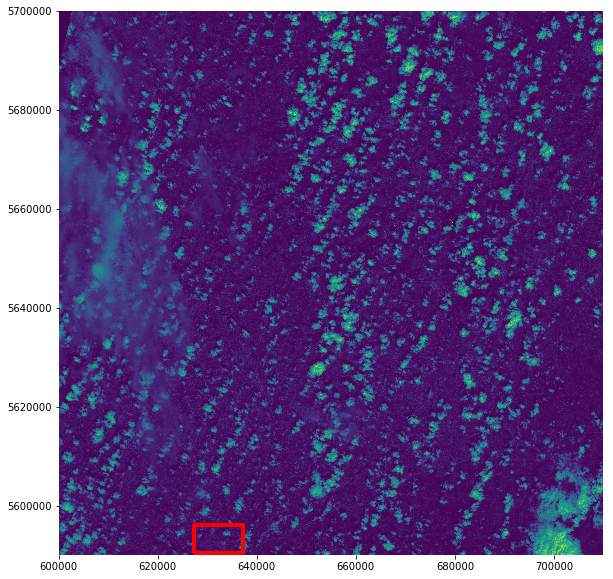

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot image

# First image of the list
#im_file = list_im_to_clip[0]

# A cloudy image
im_file = [s for s in list_im_to_clip if all(xs in s for xs in ['20200621','B04'])][0]

src = rasterio.open(im_file, "r")
rasterio.plot.show(src, ax=ax)

# Plot vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 4, ax=ax)

plt.box(False)

### 2.2 Clip images

In [77]:
for im_file in list_im_to_clip:

    im_file_roi = f'{clipped_path}{os.path.basename(im_file)[:-4]}_ROI.tif'
    
    if not os.path.isfile(im_file_roi):
        
        # Open file
        src = rasterio.open(im_file, "r")

        # Crop the raster to the extent of the shape
        out_image, out_transform = rasterio.mask.mask(src,
                                                      roi_gdf.geometry,
                                                      all_touched=True,
                                                      crop=True)

        # Update metadata
        out_meta = src.meta

        out_meta.update(driver='GTiff',
                        width = out_image.shape[2],
                        height = out_image.shape[1],
                        transform = out_transform)

        # Write clipped image
        dst = rasterio.open(im_file_roi, "w", **out_meta)
        dst.write(out_image)

        # Close rasterio objects
        src.close()
        dst.close()


        print(f'A new raster file is created : {im_file_roi}')

print('--> All images are clipped !')


--> All images are clipped !


**Check if clipped image is located inside the ROI**

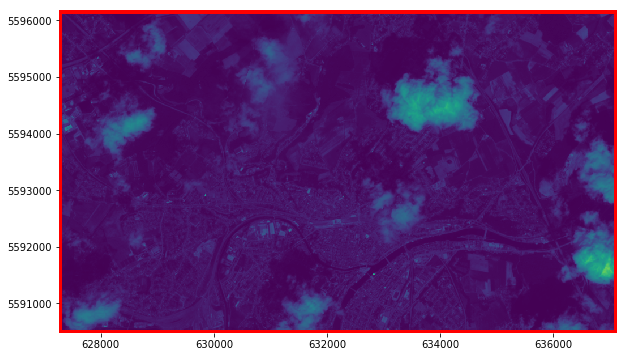

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot image

# First image of the list
#im_file = glob.glob(f'{clipped_path}*_B*.tif')[0]

# A cloudy image
im_file = glob.glob(f'{clipped_path}*20200621*B04*.tif')[0]


src = rasterio.open(im_file, "r")
rasterio.plot.show(src, ax=ax)

# Plot vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 6, ax=ax)

plt.box(False)

## 3. Apply Scene Classification map (SCL) on reflectance images to mask invalid pixels

### 3.1 Get a list with all reflectance bands clipped on the ROI

In [79]:
list_im_ROI = glob.glob(f'{clipped_path}*_B*_ROI.tif')

print(f'There are {len(list_im_ROI)} images where we have to apply SCL map')

There are 36 images where we have to apply SCL map


### 3.2 Apply SCL

In [81]:
for im_file in list_im_ROI:
    
    # Get date of image
    date = os.path.basename(im_file)[7:7+15]
    
    # Find SCL corresponding to the given reflectances image
    scl_file = glob.glob(f'{clipped_path}*{date}*SCL_10m_ROI.tif')[0]
    scl_file = scl_file.replace('\\','/')
    
    im_file_scl = f'{masked_path}{os.path.basename(im_file)[:-4]}_SCL.tif'

    if not os.path.isfile(im_file_scl):
        
        # Open SCL and change invalid pixels categories by NaN
        src = rasterio.open(scl_file, "r")

        # Read file as numpy array
        SCL = src.read(1)
        src.close()

        #print('Scene Classification map')
        #show(SCL, cmap='Set3')

        SCL = SCL.astype(float)

        SCL[SCL == 0] = np.nan    # No data
        SCL[SCL == 1] = np.nan    # Saturated or defective
        SCL[SCL == 2] = np.nan    # Dark area pixels
        SCL[SCL == 3] = np.nan    # Cloud shadows
        SCL[SCL == 4] = 1         # Vegetation
        SCL[SCL == 5] = 1         # Not vegetated
        SCL[SCL == 6] = 1         # Water
        SCL[SCL == 7] = 1         # Unclassified
        SCL[SCL == 8] = np.nan    # Cloud medium probability
        SCL[SCL == 9] = np.nan    # Cloud high probability
        SCL[SCL == 10] = np.nan   # Thin cirrus
        SCL[SCL == 11] = np.nan   # Snow

        # Open file
        src = rasterio.open(im_file, "r")

        # Read file as numpy array
        im = src.read(1)

        # Update metadata
        profile = src.profile
        profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
                       nodata=nodata_val,     # Set nodata value in metadata
                       compress='lzw')        # Compression option

        # Mask image reflectance with SCL
        im_SLC = im * SCL

        # Change numpy NaN by nodata_val (e.g. -10000)
        im_SLC[np.isnan(im_SLC)] = nodata_val

        # Change the array's type : from float to integer 16
        im_SLC = im_SLC.astype(np.int16)

        # Write image
        dst = rasterio.open(im_file_scl, 'w', **profile)
        dst.write(im_SLC, 1)

        # Close rasterio objects
        src.close()
        dst.close()

        print(f'A new raster file is created : {im_file_scl}')
    

print('--> SCL is applied on all images !')


--> SCL is applied on all images !


**Check if the SCL was correctly applied**

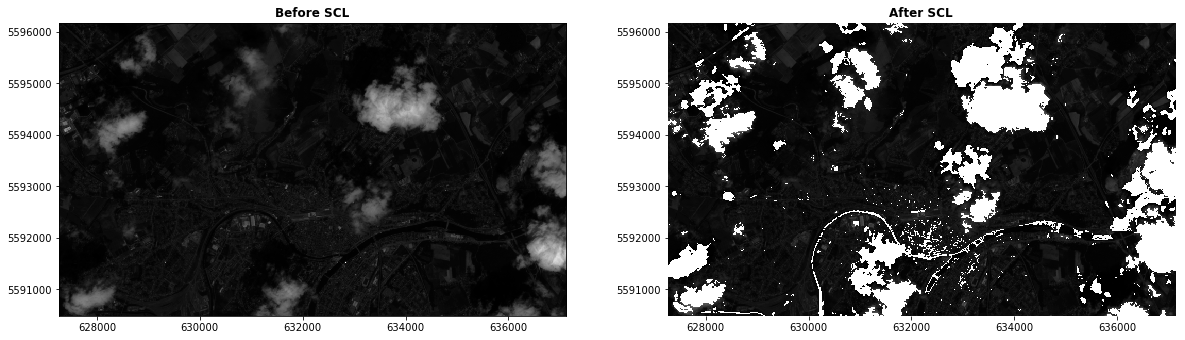

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))


im_file_clip = glob.glob(f'{clipped_path}*20200621*B04*.tif')[0]

src = rasterio.open(im_file_clip, "r")
rasterio.plot.show(src, ax=ax1, cmap='Greys_r', title="Before SCL")


im_file_scl = glob.glob(f'{masked_path}*20200621*B04*.tif')[0]

src = rasterio.open(im_file_scl, "r")
rasterio.plot.show(src, ax=ax2, cmap='Greys_r', title="After SCL")

plt.box(False)